In [41]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, HTML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
# global settings
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

plt.figure(figsize=(10, 3))

plt.style.use('seaborn-whitegrid')

np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

%matplotlib inline



# Problema

Prevendo Faturamento da Empresa

# Objetivos/Questões

* Identificar resultado das campanhas de marketing
* Quais clientes serão mais rentáveis? Faturamento > 500
* Quais os principais segmentos de clientes?
* Previsão de faturamento, de modo a definir estratégias de marketing
* Qual é o Lifetime value da base de clientes da empresa?

In [43]:
# carregando dados
df_raw = pd.read_csv("compras.txt", sep="\t",  names=['cliente_id', 'valor_compra', 'data_compra'] 
                    , parse_dates=['data_compra'])

In [44]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51243 entries, 0 to 51242
Data columns (total 3 columns):
cliente_id      51243 non-null int64
valor_compra    51243 non-null float64
data_compra     51243 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.2 MB


In [45]:
df_raw.head()

,cliente_id,valor_compra,data_compra
0,760,25.0,2009-11-06
1,860,50.0,2012-09-28
2,1200,100.0,2005-10-25
3,1420,50.0,2009-07-09
4,1940,70.0,2013-01-25


In [46]:
# Feature engineering
data_referencia = df_raw.data_compra.max() + pd.Timedelta("1 day")

df_raw["ano_compra"] = df_raw.data_compra.dt.year# pd.DatetimeIndex(df_raw['data_compra']).year
#df_raw["days_since"] = (pd.Timestamp('2016-01-01') - df_raw["data_compra"]).dt.days
df_raw["days_since"] = (data_referencia - df_raw["data_compra"]).dt.days


In [47]:
df_raw.head()

,cliente_id,valor_compra,data_compra,ano_compra,days_since
0,760,25.0,2009-11-06,2009,2247
1,860,50.0,2012-09-28,2012,1190
2,1200,100.0,2005-10-25,2005,3720
3,1420,50.0,2009-07-09,2009,2367
4,1940,70.0,2013-01-25,2013,1071


# EAD - Exploração dos dados

In [48]:
#sumário
df_raw.describe()

,cliente_id,valor_compra,ano_compra,days_since
count,51243.000000,51243.000000,51243.000000,51243.000000
mean,108934.547938,62.337195,2010.869699,1631.939309
std,67650.610139,156.606801,2.883072,1061.076889
min,10.000000,5.000000,2005.000000,1.000000
25%,57720.000000,25.000000,2009.000000,733.000000
50%,102440.000000,30.000000,2011.000000,1500.000000
75%,160525.000000,60.000000,2013.000000,2540.000000
max,264200.000000,4500.000000,2015.000000,4016.000000


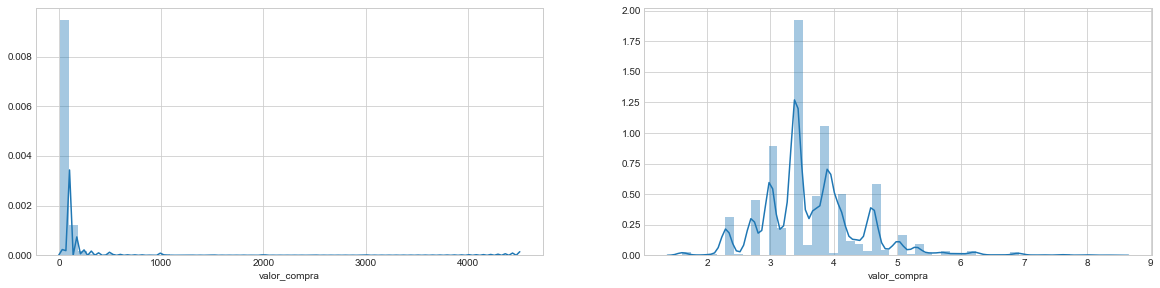

In [49]:
# distrubicao valor de compra


plt.figure(figsize=(20, 10))

plt.subplot(221)
#df_raw["valor_compra"].plot.hist()
sns.distplot(df_raw["valor_compra"])

plt.subplot(222)
sns.distplot(np.log(df_raw["valor_compra"]))


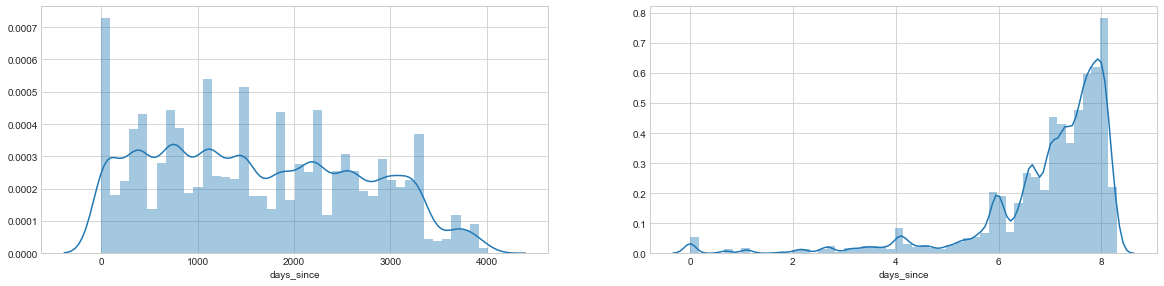

In [50]:
plt.figure(figsize=(20, 10))

plt.subplot(221)
#df_raw["days_since"].plot.hist()
sns.distplot(df_raw["days_since"])

plt.subplot(222)
sns.distplot(np.log(df_raw["days_since"]))

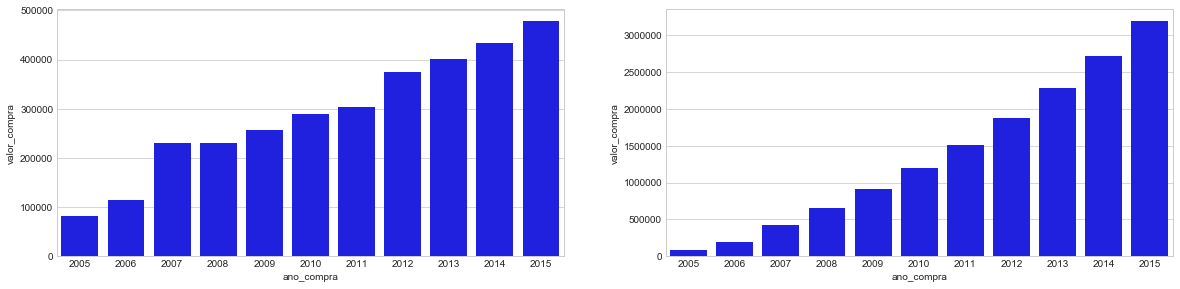

In [51]:
plt.figure(figsize=(20, 10))

#faturamento anual 
df_faturamento_anual = df_raw.groupby("ano_compra")["valor_compra"].sum()

plt.subplot(221)
sns.barplot(y=  df_faturamento_anual, x=df_faturamento_anual.index, color="blue")


#faturamento anual acumulado 
plt.subplot(222)
sns.barplot(y=  df_faturamento_anual.cumsum(), x=df_faturamento_anual.index, color="blue")

In [52]:
#sumariar dados por cliente

def sumarizar_por_cliente(df):
    aggregations = {
        "days_since" : {"compra_mais_recente": "min", "primeira_compra": "max", "fequencia": "count"},
        "valor_compra" : {"media_compra": "mean", "valor_maximo_compra" : "max", "faturamento" : "sum"}
    }
    
    df = df.groupby(["cliente_id"]).agg(aggregations)
    df.columns = ["compra_mais_recente", "primeira_compra", "fequencia", "media_compra", "valor_maximo_compra", "faturamento"]
    
    return df

df_cliente = sumarizar_por_cliente(df_raw)
#Quais são os top 10 clientes
df_cliente.sort_values("faturamento", ascending=False).head(10)

,compra_mais_recente,primeira_compra,fequencia,media_compra,valor_maximo_compra,faturamento
cliente_id,,,,,,
13610,1307,3657,8,3043.750000,3100.0,24350.0
144610,1,1988,18,944.444444,1000.0,17000.0
98550,406,2784,7,2215.285714,4000.0,15507.0
164930,284,1697,5,2800.000000,3000.0,14000.0
141340,590,2038,6,2225.166667,4419.0,13351.0
54170,232,3313,10,1300.000000,2000.0,13000.0
98790,584,1204,3,4000.000000,4000.0,12000.0
5330,205,3892,11,997.727273,1525.0,10975.0
20200,3,3830,10,1010.000000,1500.0,10100.0


# Segmentacão estatística dos clientes

In [13]:
from sklearn.preprocessing import StandardScaler

df_std = df_cliente.copy()

# aplicando transformação baseada em log para converter dados em distribuicao normal
df_std["media_compra"] = np.log(df_std["media_compra"])
df_std["faturamento"] = np.log(df_std["faturamento"])

# padronizacao dos dados
scaler = StandardScaler()
df_std = scaler.fit_transform(df_std)

## Objetivo: segmentar hierarquicamente os clientes

*Hierarchical Clustering* 
Método que agrupa dados:

* Calculando a distância entre cada ponto e seus vizinhos mais próximos (Matriz de distância)
* Agrupando vizinhos mais próximos



### Dendograma

Usando scipy para gerar dendrogramas

In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix_ward = linkage(df_std, 'ward')
linkage_matrix_complete = linkage(df_std, 'complete')
linkage_matrix_avg = linkage(df_std, 'average')

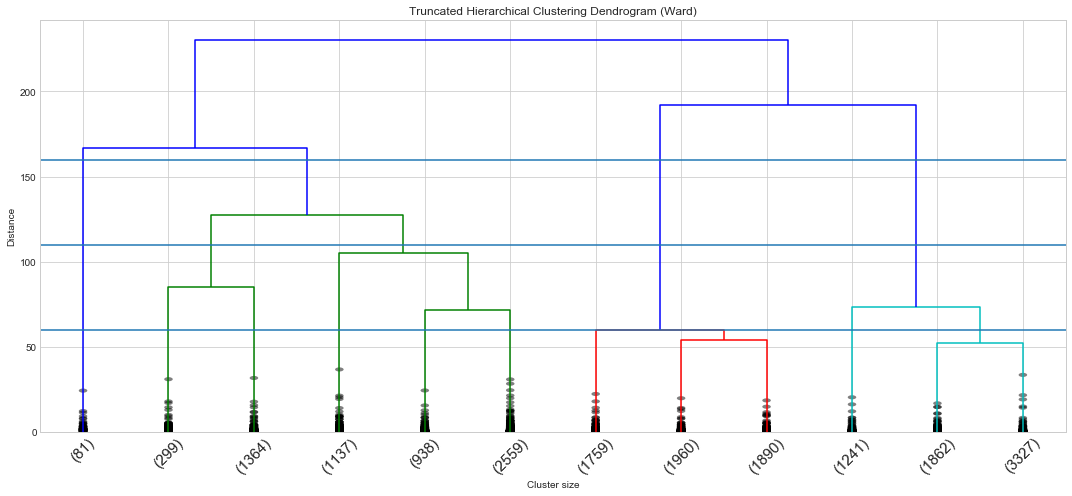

In [15]:
#plotar dendograma

figure = plt.figure(figsize=(15, 7))

dendrogram(
    linkage_matrix_ward,
    #color_threshold=0,
    truncate_mode="lastp", # show only the last p merged clusters
    p=12, # show only the last p merged clusters
    leaf_rotation=45.,
    leaf_font_size=15.,
    show_contracted = True # to get a distribution impression in truncated branche
)
plt.title('Truncated Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.tight_layout()


plt.axhline(y=160)
plt.axhline(y=110)
plt.axhline(y=60)

plt.show()

### Avaliando os clusters com o Coeficiênte de Correlação Copenético

Isso (muito resumidamente) compara (correlaciona) as distâncias pares de todas as suas amostras com aquelas implícitas pelo agrupamento hierárquico. Quanto mais próximo o valor estiver de 1, melhor o agrupamento 

In [16]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(linkage_matrix_ward, pdist(df_std))
print ("Método Ward", c)


c, coph_dists = cophenet(linkage_matrix_avg, pdist(df_std))
print ("Método Avg", c)

c, coph_dists = cophenet(linkage_matrix_complete, pdist(df_std))
print ("Método Complete", c)

Método Ward 0.4399498222525251
Método Avg 0.8184777075188433
Método Complete 0.6735971684101145


### Determinando o Número de Clusters

In [17]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [18]:
# set cut-off to 5
max_d = 5  # max_d as in max_distance

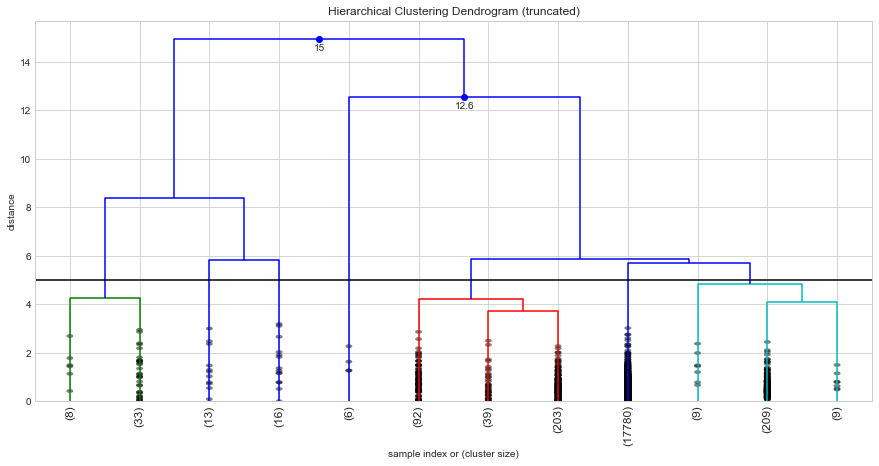

In [19]:
figure = plt.figure(figsize=(15, 7))

fancy_dendrogram(
    linkage_matrix_avg,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
    max_d=max_d,  # plot a horizontal cut-off line
    #color_threshold=0,
)
plt.show()

Em geral, para um valor de corte escolhido max_d, você pode simplesmente contar o número de interseções com linhas verticais do dendrograma para obter o número de agrupamentos formados. Digamos que escolhemos um corte de max_d = 5, teríamos 7 clusters finais:

## Gerando agrupamento hierárquico

<img src="https://chrisalbon.com/images/machine_learning_flashcards/Aggomerative_Clustering_print.png" class="flashcard center-block">

Em scikit-learn, AgglomerativeClustering usa o parâmetro linkage para determinar a estratégia de fusão para minimizar:

1. variância dos clusters criados (ward)
2. média das distâncias entre observação dos pares de clusters (average)
3. distância máxima entre as observações dos pares de clusters (complete).


Dois outros parâmetros são úteis para saber. Primeiro, o parâmetro de afinidade (*affinity*) determina a métrica de distância usada para a ligação (linkage) (minkowski, euclidean, etc.). Segundo, *n_clusters* define o número de clusters que o algoritmo de clustering tentará encontrar. Ou seja, os clusters são sucessivamente mesclados até que restem apenas n_clusters.


In [20]:
from sklearn.cluster import AgglomerativeClustering

In [21]:
# Compute clustering

k = 7 
Hclustering  = AgglomerativeClustering(n_clusters=k, linkage='average', affinity="euclidean" )

Hclustering.fit(df_std)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=7, pooling_func='deprecated')

In [22]:
# cluster labels for each point
Hclustering.labels_

array([6, 6, 6, ..., 6, 6, 4], dtype=int64)

## Segmentação Gerencial

Utilizando regras definidas pelo negócio para realizar segmentação de clientes

In [53]:
def seg_negocial(df):
    if "segmento" in df.columns.tolist():
        df.drop(["segmento"], axis=1, inplace=True)
    
    df["segmento"] = "NA"
    df.loc[df.compra_mais_recente > 365*3, 'segmento'] = "Inativo"
    df.loc[(df.compra_mais_recente <= 365*3) & (df.compra_mais_recente > 365*2), 'segmento'] = "Frio"
    df.loc[(df.compra_mais_recente <= 365*2) & (df.compra_mais_recente > 365*1), 'segmento'] = "Quente"
    df.loc[df.compra_mais_recente <= 365, 'segmento'] = "Ativo"

    df.loc[(df.segmento == "Quente") & (df.primeira_compra <= 365*2) , 'segmento'] = "Novo Quente"
    df.loc[(df.segmento == "Quente") & (df.media_compra < 100) , 'segmento'] = "Quente - Valor Baixo"
    df.loc[(df.segmento == "Quente") & (df.media_compra >= 100) , 'segmento'] = "Quente - Valor Alto"

    df.loc[(df.segmento == "Ativo") & (df.primeira_compra <= 365) , 'segmento'] = "Novo Ativo"
    df.loc[(df.segmento == "Ativo") & (df.media_compra < 100) , 'segmento'] = "Ativo - Valor Baixo"
    df.loc[(df.segmento == "Ativo") & (df.media_compra >= 100) , 'segmento'] = "Ativo - Valor Alto"
    
    
    categories = ["Inativo", "Frio",
                  "Quente - Valor Alto", "Quente - Valor Baixo", "Novo Quente",
                   "Ativo - Valor Alto", "Ativo - Valor Baixo", "Novo Ativo"]
    
    df.segmento = df.segmento.astype('category', categories=categories, ordered=True)
    
    return df

In [54]:
# quantidade de clientes por segmento em 2015
df_cliente_2015 = seg_negocial(df_cliente)
df_cliente_2015.segmento.value_counts()

Inativo                 9158
Ativo - Valor Baixo     3313
Frio                    1903
Novo Ativo              1512
Novo Quente              938
Quente - Valor Baixo     901
Ativo - Valor Alto       573
Quente - Valor Alto      119
Name: segmento, dtype: int64

In [55]:
# quantidade de clientes por segmento em 2014

df_raw_2014 = df_raw[df_raw.days_since > 365]
df_cliente_2014 = sumarizar_por_cliente(df_raw_2014)

df_cliente_2014.compra_mais_recente = df_cliente_2014.compra_mais_recente - 365
df_cliente_2014.primeira_compra = df_cliente_2014.primeira_compra - 365


df_cliente_2014 = seg_negocial(df_cliente_2014)
df_cliente_2014.segmento.value_counts()


Inativo                 7512
Ativo - Valor Baixo     3011
Frio                    2153
Novo Ativo              1437
Novo Quente             1250
Quente - Valor Baixo     956
Ativo - Valor Alto       475
Quente - Valor Alto      111
Name: segmento, dtype: int64

# LTV - Life Time Value

In [56]:
# Computando a matriz de transição de segmentos entre 2014 e 2015

new_data = pd.merge(df_cliente_2014, df_cliente_2015,  how='outer', left_index=True, right_index=True) # on='cliente_id',
display(new_data.head())


df_transition = pd.crosstab(new_data.segmento_x, new_data.segmento_y)

display(df_transition)



# Divide cada linha pela soma
df_transition = df_transition.div(df_transition.sum(axis=1), axis=0)
df_transition




,compra_mais_recente_x,primeira_compra_x,fequencia_x,media_compra_x,valor_maximo_compra_x,faturamento_x,segmento_x,compra_mais_recente_y,primeira_compra_y,fequencia_y,media_compra_y,valor_maximo_compra_y,faturamento_y,segmento_y
cliente_id,,,,,,,,,,,,,,
10,3464.0,3464.0,1.0,30.0,30.0,30.0,Inativo,3829,3829,1,30.000000,30.0,30.0,Inativo
80,302.0,3386.0,6.0,70.0,80.0,420.0,Ativo - Valor Baixo,343,3751,7,71.428571,80.0,500.0,Ativo - Valor Baixo
90,393.0,3418.0,10.0,115.8,153.0,1158.0,Quente - Valor Alto,758,3783,10,115.800000,153.0,1158.0,Frio
120,1036.0,1036.0,1.0,20.0,20.0,20.0,Frio,1401,1401,1,20.000000,20.0,20.0,Inativo
130,2605.0,3345.0,2.0,50.0,60.0,100.0,Inativo,2970,3710,2,50.000000,60.0,100.0,Inativo


segmento_y,Inativo,Frio,Quente - Valor Alto,Quente - Valor Baixo,Novo Quente,Ativo - Valor Alto,Ativo - Valor Baixo,Novo Ativo
segmento_x,,,,,,,,
Inativo,7227,0,0,0,0,35,250,0
Frio,1931,0,0,0,0,22,200,0
Quente - Valor Alto,0,75,0,0,0,35,1,0
Quente - Valor Baixo,0,689,0,0,0,1,266,0
Novo Quente,0,1139,0,0,0,15,96,0
Ativo - Valor Alto,0,0,119,0,0,354,2,0
Ativo - Valor Baixo,0,0,0,901,0,22,2088,0
Novo Ativo,0,0,0,0,938,89,410,0


segmento_y,Inativo,Frio,Quente - Valor Alto,Quente - Valor Baixo,Novo Quente,Ativo - Valor Alto,Ativo - Valor Baixo,Novo Ativo
segmento_x,,,,,,,,
Inativo,0.962061,0.000000,0.000000,0.000000,0.000000,0.004659,0.033280,0.0
Frio,0.896888,0.000000,0.000000,0.000000,0.000000,0.010218,0.092894,0.0
Quente - Valor Alto,0.000000,0.675676,0.000000,0.000000,0.000000,0.315315,0.009009,0.0
Quente - Valor Baixo,0.000000,0.720711,0.000000,0.000000,0.000000,0.001046,0.278243,0.0
Novo Quente,0.000000,0.911200,0.000000,0.000000,0.000000,0.012000,0.076800,0.0
Ativo - Valor Alto,0.000000,0.000000,0.250526,0.000000,0.000000,0.745263,0.004211,0.0
Ativo - Valor Baixo,0.000000,0.000000,0.000000,0.299236,0.000000,0.007307,0.693457,0.0
Novo Ativo,0.000000,0.000000,0.000000,0.000000,0.652749,0.061935,0.285317,0.0


## Usando a matriz de transição para fazer previsões

In [57]:
# Inicializa a matriz com o número de clientes em cada segmento hoje e após 10 períodos (anos)
index = df_cliente_2014.segmento.cat.categories
columns = range(2015, 2026)

df_segmentos = pd.DataFrame(index=index, columns=[str(col) for col in columns])
df_segmentos.fillna(0, inplace=True)

df_segmentos["2015"] = df_cliente_2015.segmento.value_counts(sort=False).values

df_segmentos

,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
Inativo,9158,0,0,0,0,0,0,0,0,0,0
Frio,1903,0,0,0,0,0,0,0,0,0,0
Quente - Valor Alto,119,0,0,0,0,0,0,0,0,0,0
Quente - Valor Baixo,901,0,0,0,0,0,0,0,0,0,0
Novo Quente,938,0,0,0,0,0,0,0,0,0,0
Ativo - Valor Alto,573,0,0,0,0,0,0,0,0,0,0
Ativo - Valor Baixo,3313,0,0,0,0,0,0,0,0,0,0
Novo Ativo,1512,0,0,0,0,0,0,0,0,0,0


In [58]:
# calculando multiplicacao de matrizes

for i in range(1,11):
    df_segmentos[df_segmentos.columns[i]] = df_segmentos [  df_segmentos.columns[i-1]].dot(df_transition.values)

df_segmentos.round()


,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
Inativo,9158,10517.0,11539.0,12636.0,12940.0,13186.0,13386.0,13542.0,13664.0,13759.0,13834.0
Frio,1903,1584.0,1711.0,874.0,821.0,782.0,740.0,709.0,684.0,665.0,650.0
Quente - Valor Alto,119,144.0,165.0,160.0,156.0,152.0,149.0,146.0,143.0,141.0,139.0
Quente - Valor Baixo,901,991.0,1058.0,989.0,938.0,884.0,844.0,813.0,789.0,771.0,756.0
Novo Quente,938,987.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ativo - Valor Alto,573,657.0,639.0,624.0,607.0,593.0,581.0,571.0,562.0,554.0,547.0
Ativo - Valor Baixo,3313,3537.0,3305.0,3134.0,2954.0,2820.0,2717.0,2637.0,2575.0,2527.0,2490.0
Novo Ativo,1512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


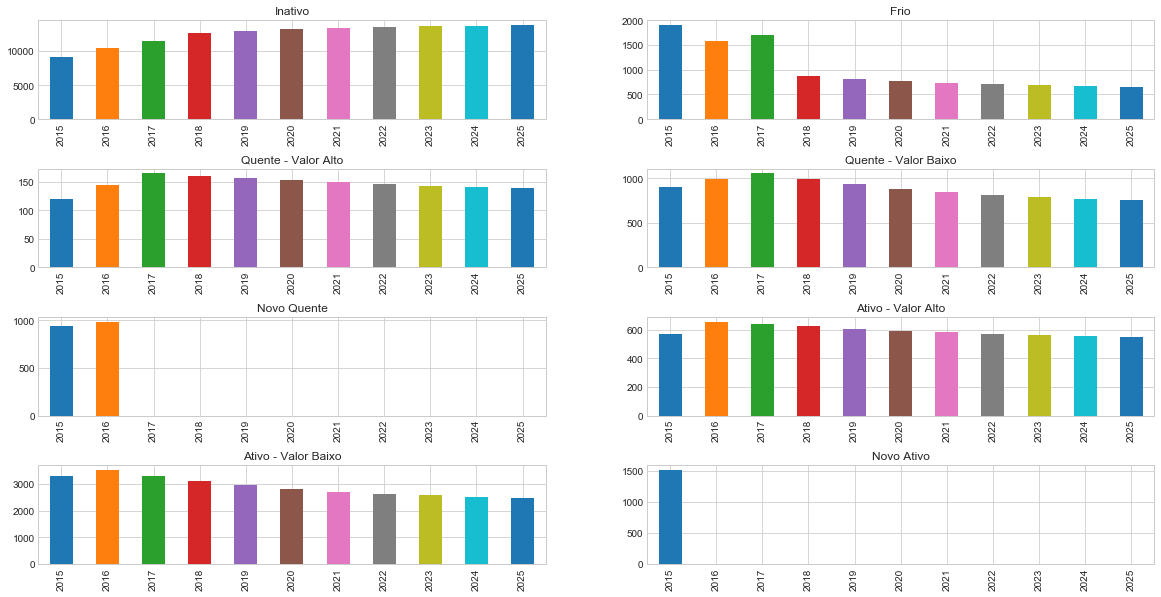

In [29]:
# plotar projeção até 2025 para cada segmento

i = 1
f = plt.figure(figsize=(20,10))
for idx in df_segmentos.index.tolist():
    plt.subplot(4,2,i)
    df_segmentos.loc[idx].plot.bar(title=idx)
    i += 1


plt.subplots_adjust(hspace=0.5)
plt.show()

### Faturamento anual por segmento

In [59]:
# extraindo faturamento em 2015
df_faturamento_2015 = df_raw[df_raw.ano_compra == 2015].groupby("cliente_id")[["valor_compra"]].sum()
df_faturamento_2015.columns = ["faturamento_2015"]

df_cliente_2015 = df_cliente_2015.merge(df_faturamento_2015, right_index=True, left_index=True, how="outer")

# Faturamento anual por segmento
yearly_revenue = df_cliente_2015.groupby(["segmento"])["faturamento_2015"].sum().values
yearly_revenue

array([     0.  ,      0.  ,      0.  ,      0.  ,      0.  , 185405.  ,
       173289.92, 119699.21])

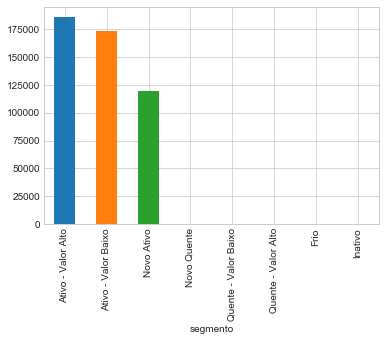

In [60]:
# Segmentos que deve ser tratados com mais atenção
# Quais os principais segmentos de clientes?
df_cliente_2015.groupby(["segmento"])["faturamento_2015"].sum().sort_values(ascending=False).plot.bar()

In [61]:
# Computando o faturamento por segmento
revenue_per_segment = df_segmentos.apply(lambda col: col * yearly_revenue).round()
revenue_per_segment

,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
Inativo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Frio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Quente - Valor Alto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Quente - Valor Baixo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Novo Quente,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ativo - Valor Alto,106237065.0,121759716.0,118401353.0,115750854.0,112626007.0,109997135.0,107736692.0,105791237.0,104123716.0,102697908.0,101481465.0
Ativo - Valor Baixo,574109505.0,612856824.0,572789525.0,543043107.0,511913554.0,488735238.0,470833348.0,456962588.0,446236110.0,437942872.0,431533135.0
Novo Ativo,180985206.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Previsão de faturamento

2015    861331776.0
2016    734616540.0
2017    691190878.0
2018    658793961.0
2019    624539561.0
2020    598732373.0
2021    578570040.0
2022    562753825.0
2023    550359826.0
2024    540640780.0
2025    533014600.0
dtype: float64

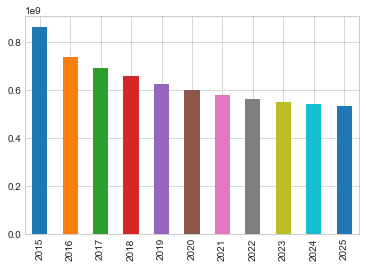

In [62]:
# Faturamento anual
yearly_revenue = revenue_per_segment.sum()
display(yearly_revenue.round())
yearly_revenue.plot.bar()

2015    8.613318e+08
2016    1.595948e+09
2017    2.287139e+09
2018    2.945933e+09
2019    3.570473e+09
2020    4.169205e+09
2021    4.747775e+09
2022    5.310529e+09
2023    5.860889e+09
2024    6.401530e+09
2025    6.934544e+09
dtype: float64

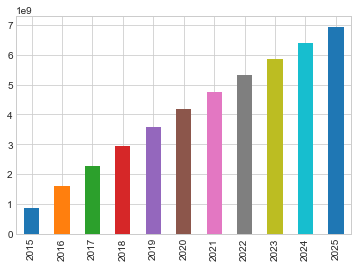

In [63]:
# Faturamento acumulado
cumulated_revenue = yearly_revenue.cumsum()
display(cumulated_revenue.round())
cumulated_revenue.plot.bar()

In [64]:
# Criando um fator de desconto

discount_rate = 0.10
discount = [1 / ((1 + discount_rate) ** i)    for i in range(11)]
discount

[1.0,
 0.9090909090909091,
 0.8264462809917354,
 0.7513148009015775,
 0.6830134553650705,
 0.6209213230591549,
 0.5644739300537772,
 0.5131581182307065,
 0.4665073802097331,
 0.42409761837248455,
 0.3855432894295314]

2015    861331776.0
2016    667833218.0
2017    571232131.0
2018    494961654.0
2019    426568924.0
2020    371765697.0
2021    326587704.0
2022    288781694.0
2023    256746921.0
2024    229284467.0
2025    205500202.0
dtype: float64

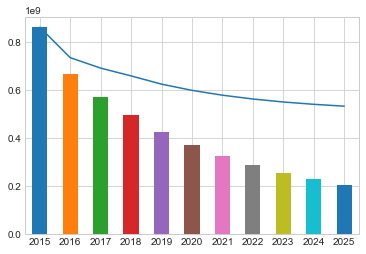

In [65]:
# Faturamento anual com fator de desconto

disc_yearly_revenue = yearly_revenue * discount
display(disc_yearly_revenue.round())

disc_yearly_revenue.plot.bar()
yearly_revenue.plot.line()

2015    8.613318e+08
2016    1.529165e+09
2017    2.100397e+09
2018    2.595359e+09
2019    3.021928e+09
2020    3.393693e+09
2021    3.720281e+09
2022    4.009063e+09
2023    4.265810e+09
2024    4.495094e+09
2025    4.700594e+09
dtype: float64

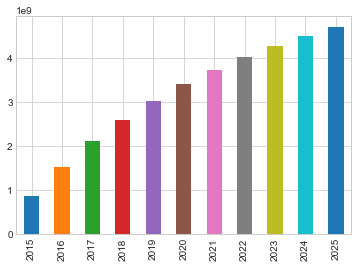

In [66]:
# Faturamento acumulado com fator de desconto
disc_cumulated_revenue = disc_yearly_revenue.cumsum()
display(disc_cumulated_revenue.round())
disc_cumulated_revenue.plot.bar()

### Quanto vale nossa base de clientes em 2025?

In [67]:
disc_cumulated_revenue[-1] - yearly_revenue[0]

3839262611.321765

### Quais clientes serão mais rentáveis? Faturamento > 500